# Import libraries and data

In [116]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [117]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [214]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain.csv")
df_features

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS00022,PS01186,Glycosylation sites,Glycosylation,GlycoMine_N,GlycoMine_O,GlycoMine_C,GPI-anchor,Signal peptide,CSF
0,Q8TDC3,MSSGAKEGGGGSPAYHLPHPHPHPPQHAQYVGPYRLEKTLGKGQTG...,778,85085.7493,0.051414,0.012853,0.043702,0.065553,0.029563,0.092545,...,0,0,0.0,0.0,1,1,0,0,0,1
1,P48065,MDGKVAVQECGPPAVSWVPEEGEKLDQEDEDQVKDRGQWTNKMEFV...,614,69367.5176,0.052117,0.037459,0.030945,0.043974,0.083062,0.081433,...,0,0,2.0,2.0,1,0,0,0,0,-1
2,Q9Y250,MGSVSSLISGHSFHSKHCRASQYKLRKSSHLKKLNRYSDGLLRFGF...,596,66612.1565,0.060403,0.011745,0.041946,0.104027,0.023490,0.072148,...,0,0,1.0,1.0,1,1,0,0,0,-1
3,P0DMW5,MAASAALSAAAAAAALSGLAVRLSRSAAARGSYGAFCKGLTRTLLT...,78,8388.8176,0.230769,0.012821,0.012821,0.012821,0.064103,0.051282,...,0,0,0.0,0.0,0,0,0,0,0,-1
4,P21579,MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEK...,422,47572.5391,0.063981,0.014218,0.061611,0.082938,0.045024,0.059242,...,0,0,0.0,0.0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,Q8IZU8,MALMFTGHLLFLALLMFAFSTFEESVSNYSEWAVFTDDIDQFKTQK...,1212,139235.8716,0.067657,0.009076,0.045380,0.048680,0.063531,0.055281,...,0,0,0.0,0.0,0,0,0,0,1,-1
2538,Q4JDL3,MSSPRDFRAEPVNDYEGNDSEAEDLNFRETLPSSSQENTPRSKVFE...,420,48422.3273,0.047619,0.019048,0.057143,0.083333,0.052381,0.045238,...,0,0,0.0,0.0,0,0,0,0,0,-1
2539,Q8N4V2,MEEDLFQLRQLPVVKFRRTGESARSEDDTASGEHEVQIEGVHVGLE...,548,60768.4670,0.085766,0.023723,0.031022,0.062044,0.056569,0.082117,...,0,0,2.0,2.0,0,0,0,0,0,-1
2540,P48426,MATPGNLGSSVLASKTKTKKKHFVAQKVKLFRASDPLLSVLMWGVN...,406,46224.0440,0.056650,0.009852,0.068966,0.073892,0.046798,0.051724,...,0,0,0.0,0.0,0,1,0,0,0,-1


In [215]:
df_features["PredHel_binary"] = np.where(df_features["PredHel"] == 0, 0, 1)
df_features["PredHel"] = np.where(df_features["PredHel"] > 7, ">7", df_features["PredHel"])
df_features["PredHel"].value_counts()

## CSF data set

In [177]:
csf = pd.read_csv(data_path + "CSF/all_csf_1000plus.csv")
csf["#Studies"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].count(axis=1)

## Brain proteome (HPA)

In [178]:
brain_elevated = pd.read_csv(data_path + "Brain/HPA_all_brain_elevated_version21.tsv", sep="\t")
print("Number of brain elevated proteins according to the HPA: %i" % len(brain_elevated))
brain_elevated.dropna(subset=["Uniprot"], inplace=True)
brain_elevated.drop_duplicates(subset=["Uniprot"], inplace=True)
print("Number of brain elevated proteins with a Uniprot ID: %i" % len(brain_elevated))

brain_elevated["Uniprot"] = brain_elevated["Uniprot"].apply(keep_first_uniprot)

Number of brain elevated proteins according to the HPA: 2709
Number of brain elevated proteins with a Uniprot ID: 2546


## Create strigent data sets

In [186]:
def increase_stringency_CSF(feature_df, csf_df, i):
    
    stringent_csf = csf_df[csf_df["#Studies"]>=i]["Uniprot"]
    remove_csf = set(df_features[df_features["CSF"] == 1]["Uniprot"]) - set(stringent_csf)
    df_stringent = df_features.drop(df_features[(df_features["CSF"] == 1) & (df_features["Uniprot"].isin(remove_csf))].index)
    
    print("Number of CSF proteins to be removed:", len(remove_csf))
    print("Number of CSF proteins left:", len(df_stringent[(df_stringent["CSF"] == 1)]))   
    
    return df_stringent

# create more stirngent data sets
df_features_2plus = increase_stringency_CSF(df_features, csf, 2)
print("Number of proteins in dataset:", len(df_features_2plus))
print("-------------")
df_features_3plus = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_3plus))

Number of CSF proteins to be removed: 303
Number of CSF proteins left: 692
Number of proteins in dataset: 2239
-------------
Number of CSF proteins to be removed: 454
Number of CSF proteins left: 541
Number of proteins in dataset: 2088


In [194]:
non_CSF = df_features[df_features["CSF"] == -1]
CSF_1plus = df_features[df_features["CSF"] == 1]
CSF_2plus = df_features_2plus[df_features_2plus["CSF"] == 1]
CSF_3plus = df_features_3plus[df_features_3plus["CSF"] == 1]

df_list = [non_CSF, CSF_1plus, CSF_2plus, CSF_3plus]
names = ["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"]

# Feature Analysis

In [188]:
def get_percentages(df_list, col):
    
    perc_list = []
    for i in range(len(df_list)):
        perc_list.append(sum(df_list[i][col])/len(df_list[i]))

    return perc_list

## Subcellular localization

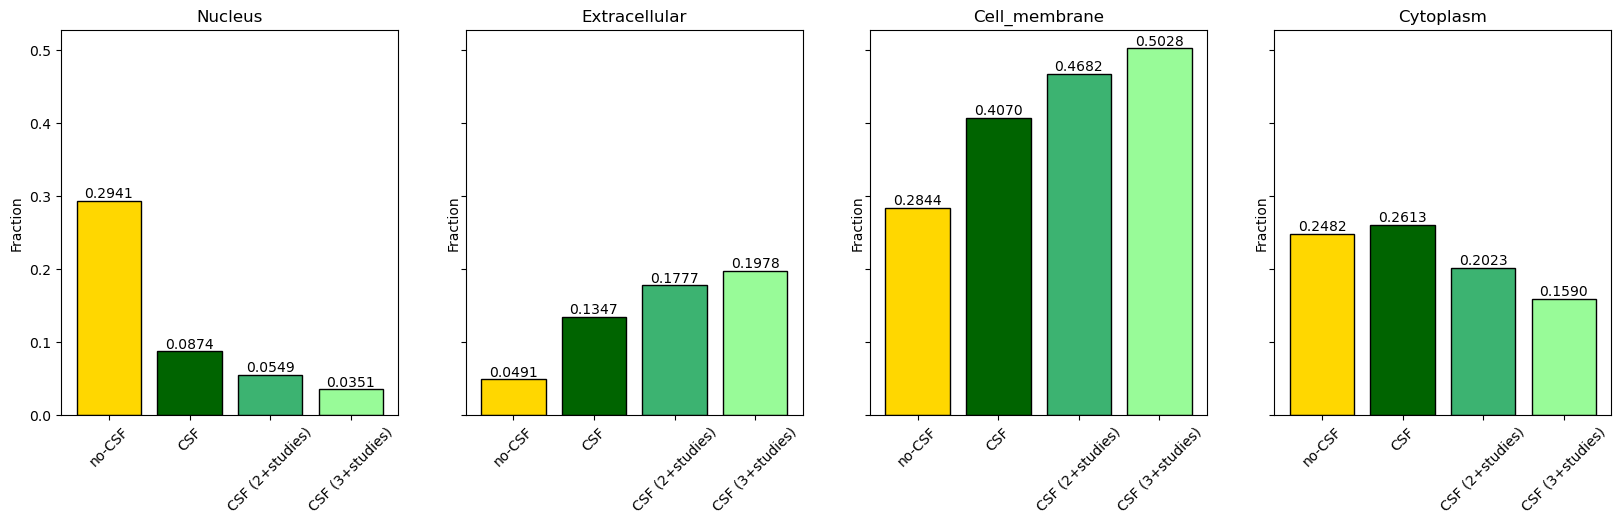

In [124]:
features = ["Nucleus", "Extracellular", "Cell_membrane", "Cytoplasm"]

# "Peroxisome"
# "Lysosome/Vacuole"
# "Plastid"

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["no-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

# save

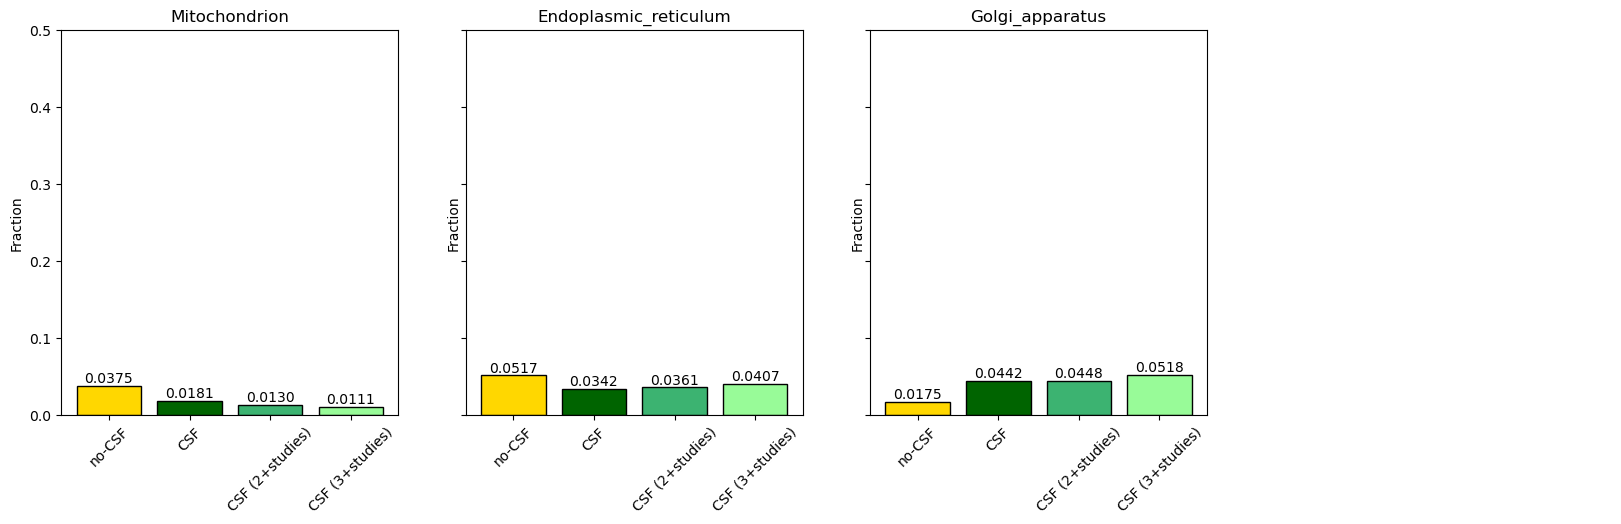

In [125]:
features = ["Mitochondrion", "Endoplasmic_reticulum", "Golgi_apparatus"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
ax[-1].axis("off")

for i in range(len(features)):
    bars = ax[i].bar(x=["no-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set(ylabel="Fraction", title=features[i], ylim=(0, 0.5))

plt.show()

# save

## Glycosylation

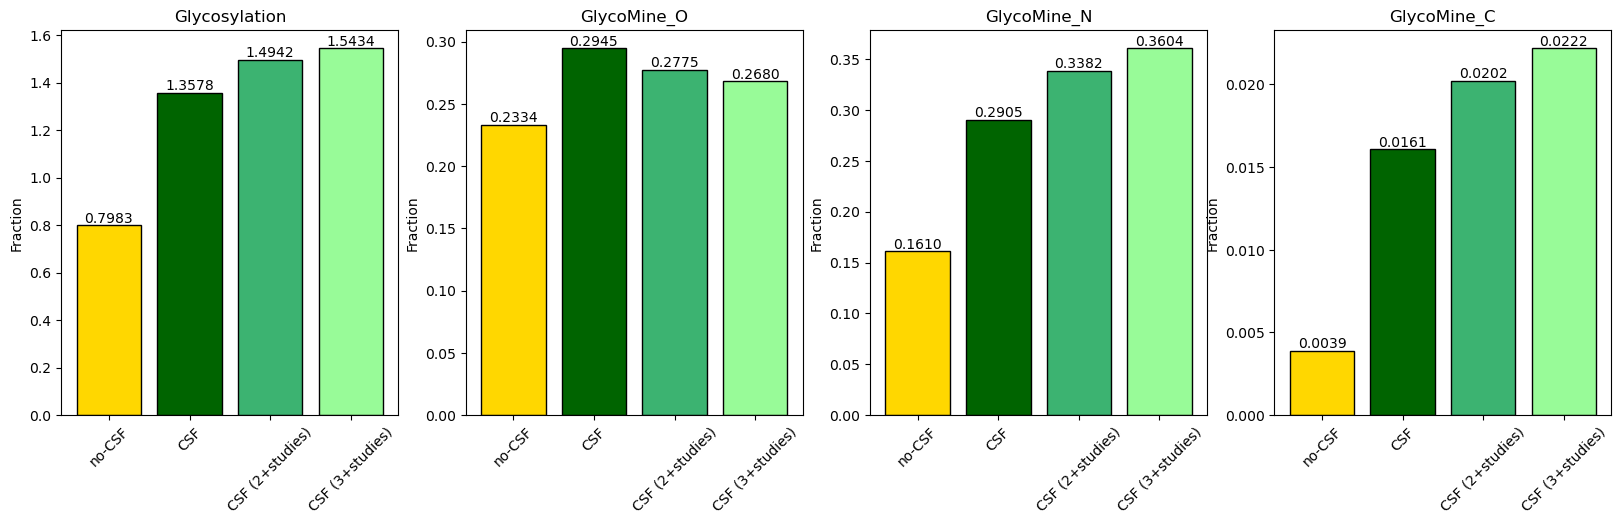

In [182]:
features = ["Glycosylation", "GlycoMine_O", "GlycoMine_N", "GlycoMine_C"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))#, sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["no-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

# save

## Motifs

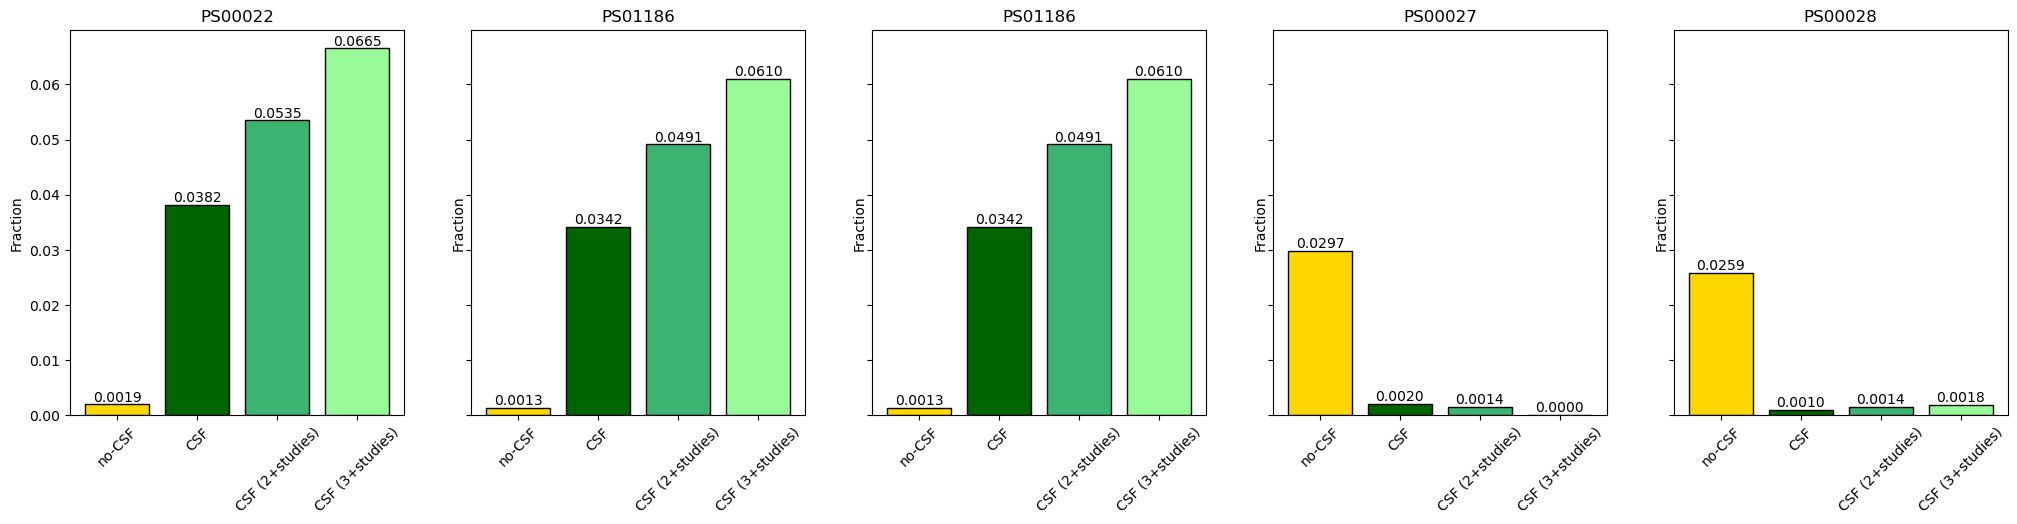

In [183]:
features = ["PS00022", "PS01186", "PS01186", "PS00027", "PS00028"]

# Cadherin-1 (PS00232)
# G-protein receptor F1 (PS00237)
# Homeobox (PS00027)
# Zinc Finger C2H2 (PS00028)
# EGF1 (PS00022)
# EGF2 (PS01186)

fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["no-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

# save

## Transmembrane

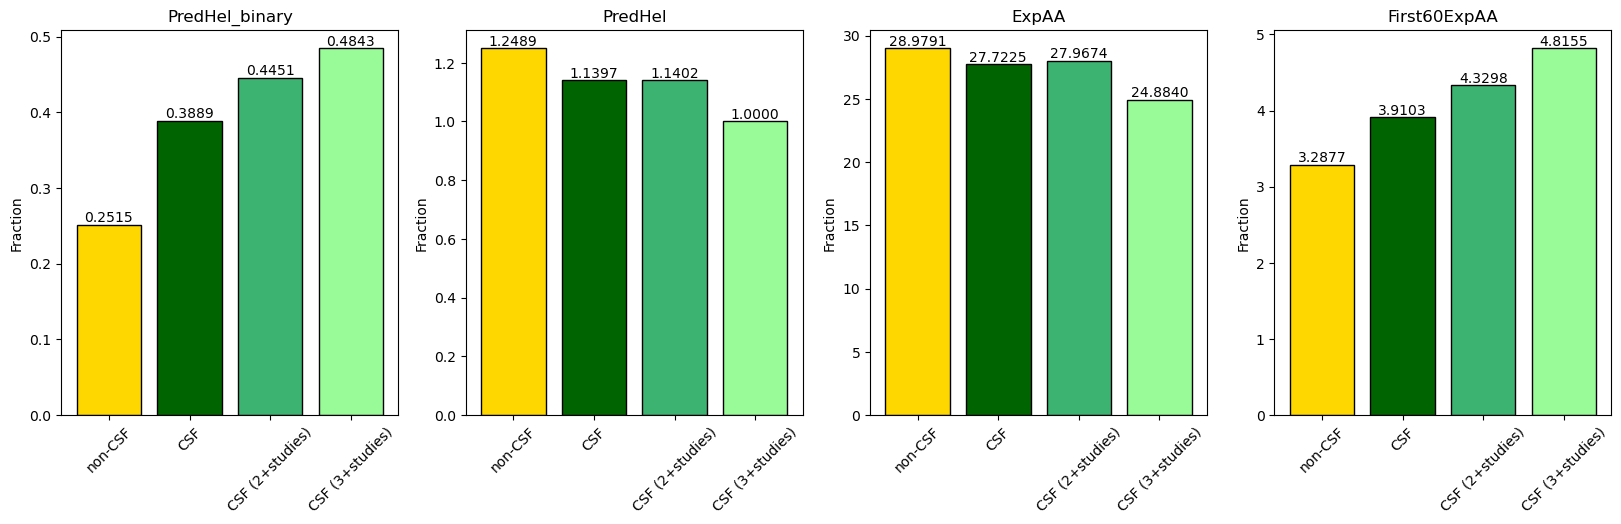

In [237]:
features = ["PredHel_binary", "PredHel", "ExpAA", "First60ExpAA"]

fig, ax = plt.subplots(1, 4, figsize=(20, 5))#, sharey=True)

for i in range(len(features)):
    bars = ax[i].bar(x=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], height=get_percentages(df_list, features[i]),
        color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
    ax[i].bar_label(bars, fmt="%.4f")
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set(ylabel="Fraction", title=features[i])

plt.show()

In [208]:
# emoty dataframe 
tm_df = pd.DataFrame()

for i, data in enumerate(df_list):
    # add proportions of transmembrane region counts to dataframe
    tm = pd.Series(data["PredHel"].value_counts(normalize=True).sort_index(), name=names[i])
    tm_df = pd.merge(tm_df, tm, left_index=True, right_index=True, how="outer")
    
tm_df.reset_index(inplace=True)

In [238]:
# aggregate values of all proteins with >7 predicted transmembrane regions
tm_df_8plus = tm_df[8:].agg([sum])
# add aggregated values to transmembrane dataframe (remove single values for aggregated values)
tm_df = pd.concat([tm_df[:8], tm_df_8plus])
tm_df.loc["sum", "index"] = ">7"

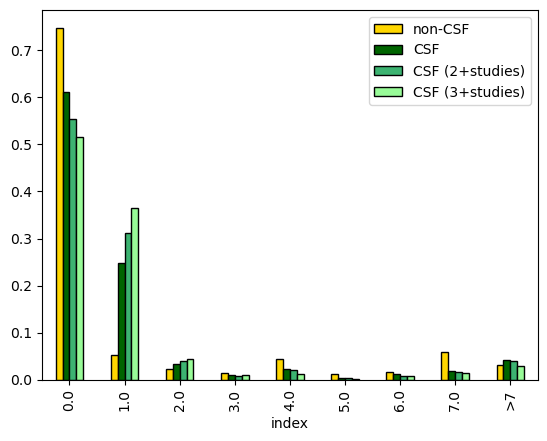

In [236]:
tm_df.plot(x="index", y=["non-CSF", "CSF", "CSF (2+studies)", "CSF (3+studies)"], kind="bar",
          color=["gold", "darkgreen", "mediumseagreen", "palegreen"], edgecolor="black")
plt.show()    

# Figures for CSF Society Meeting 2022 abstract

In [127]:
#### TO DO ####
# move to visulization notebook when it is created

In [128]:
# sns.set(style=("ticks"), font_scale=1)
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# fig.subplots_adjust(wspace=0.3)#, hspace=None)

# sns.violinplot(y="Helix_NSP",  x="CSF", data=feature_df_brain, ax=axes[0], palette=["darkred", "indianred"])
# axes[0].set(xlabel=None, ylabel="Alpha helix", xticklabels=["non-CSF", "CSF"])
# sns.violinplot(y="Sheet_NSP",  x="CSF", data=feature_df_brain, ax=axes[1], palette=["teal", "turquoise"])
# axes[1].set(xlabel=None, ylabel="Beta sheet", xticklabels=["non-CSF", "CSF"])

# plt.show()